<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Regularization

_Authors: Matt Brems + Tim Book_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

## Learning Objectives

1. Describe what a loss function is.
2. Define regularization.
3. Describe and differentiate LASSO and Ridge regularization.
4. Understand how regularization affects the bias-variance tradeoff.
5. Implement LASSO regression and Ridge regression.

## Review

<details><summary>What is the bias-variance tradeoff?</summary>

- Mean squared error can be decomposed into a bias component plus a variance component (plus a systematic error, but we don't have control over this part, so we often ignore it).
- The bias-variance tradeoff refers to the fact that taking steps to minimize bias usually comes at the expense of an increase in variance. Similarly, taking steps to minimize variance usually comes at the expense of an increase in bias.

</details>

---

<details><summary>What evidence/information would lead me to believe that my model suffers from high variance?</summary>
    
- After splitting my data into training and testing sets, if I see that my model performs way better on my training set than my testing set, this means that my model is not generalizing very well to "new" data.
- An example might be where our training MSE is substantially lower than our testing MSE, or where our training R-squared is substantially higher than our testing R-squared.
</details>

---

<details><summary>What term do we use to describe a model that suffers from high variance?</summary>

- Overfit.
</details>

## Why is high variance bad?

High variance is bad because it means that our model doesn't generalize well to new data. This means that our model looks as though it performs well on our training data but won't perform as well on new, unseen data.

---
<details><summary>How might we try to fix a model that suffers from high variance?</summary>

- Gather more data. (Although this is usually expensive and time-consuming.)
- Drop features.
- Make our existing features less complex. (i.e. get rid of interaction terms or higher order terms.)
- Choose a simpler model.
- Regularization!
</details>

## Pop Math Quiz

### Problem 1
**What is the value of $b$ that minimizes...**

$$ (y - b)^2 $$

<details><summary></summary>
When $b = y$, this expression has value 0. Since it's squared, it can't go below that.
</details>

### Problem 2
**What is the value of $b$ that minimizes...**

$$ (y - b)^2 + \alpha b^2 $$

where $\alpha > 0$?

<details><summary></summary>
This is more complicated, isn't it? You can use calculus and come up with an answer:
    
$$ \hat{b} = \frac{y}{1 + \alpha} $$

But what is the effect of $\alpha$ on our solution?
</details>

## Overview of regularization

---

"Regularizing" regression models is to:
- **automatically** avoid overfitting 
- while we fit our model
- by adding a "penalty" to our loss function.

Remember what our loss function has looked like so far:

$$
\begin{eqnarray*}
\text{minimize: }SSE &=& \sum_{i=1}^n (y_i - \hat{y}_i)^2
\end{eqnarray*}
$$

In ordinary least squares (OLS) linear regression, we find the line of best fit by selecting the values of $\hat{\pmb\beta}$ that minimize the sum of squared errors (SSE).

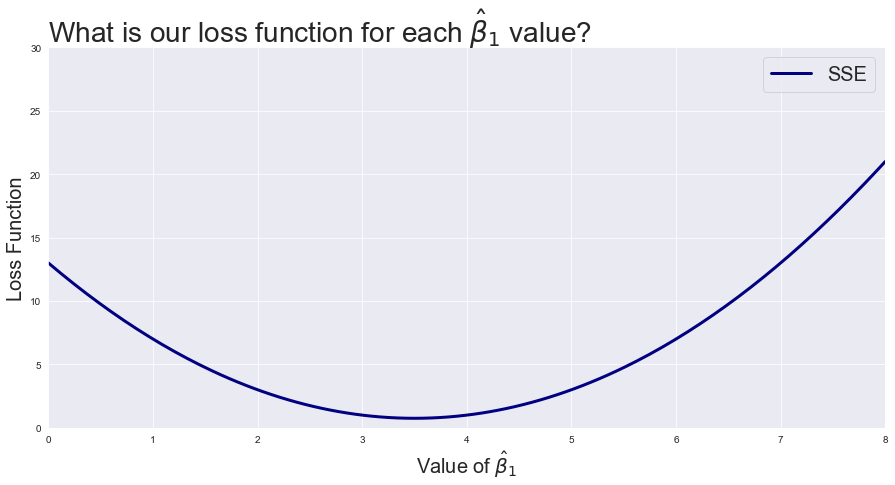

In [2]:
# Create figure.
plt.figure(figsize=(15, 7))

# Set up 200 steps between 0 and 8.
beta_1 = np.linspace(0, 8, 200)

# Create our SSE function. (This is a made up loss function!)
sse = beta_1**2 - 7*beta_1 + 13

# Set axis labels, title, and ranges.
plt.ylabel('Loss Function', fontsize=20)
plt.xlabel(r'Value of $\hat{\beta}_1$', fontsize=20) # The r allows us to typeset with LaTeX.
plt.title(r'What is our loss function for each $\hat{\beta}_1$ value?',
          fontsize=28,
          x=0,
          ha='left')
plt.xlim(0, 8)
plt.ylim(0, 30)

# Plot SSE for values of beta_1 between 0 and 8.
plt.plot(beta_1, sse, label='SSE', c='navy', linewidth=3)

plt.legend(fontsize=20);

<details><summary>Based on the above plot, what value for beta_1 should my model select?</summary>
    
- When fitting our model, we want to minimize our loss function.
- Our loss function is minimized at 3.5.
</details>

Regularization adds an extra piece to our loss function to avoid overfitting. When fitting a regularized linear regression model, we'll minimize this **new** loss function, which is the sum of squared errors plus a penalty.

$$
\begin{eqnarray*}
\text{minimize: }SSE + \text{Ridge penalty} &=& \sum_{i=1}^n (y_i - \mathbf{x}_i^T\beta)^2 + \alpha \sum_{j=1}^p \beta_j^2 \\
                                            &=& \|\mathbf{y} - \mathbf{X}\beta\|^2 + \alpha\|\beta\|^2
\end{eqnarray*}
$$

### NOTE: This is written a few ways!
In fact, most commonly in the literature, the **regularization** parameter is a $\lambda$ instead of an $\alpha$. Scikit-Learn writes $\alpha$, so we do too.

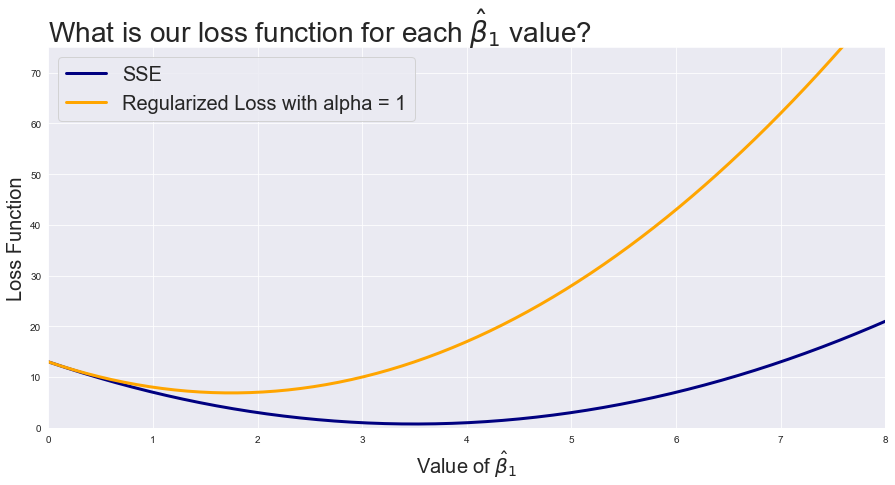

In [3]:
# Create figure.
plt.figure(figsize=(15, 7))

# Set up 200 steps between 0 and 8.
beta_1 = np.linspace(0, 8, 200)

# Create our SSE function. (This is a made up loss function!)
sse = beta_1**2 - 7*beta_1 + 13

# Create our Regularized Loss function.
alpha = 1
reg_loss = sse + alpha*beta_1**2

# Set axis labels, title, and ranges.
plt.ylabel('Loss Function', fontsize=20)
plt.xlabel(r'Value of $\hat{\beta}_1$', fontsize=20) # The r allows us to typeset with LaTeX.
plt.title(r'What is our loss function for each $\hat{\beta}_1$ value?',
          fontsize=28,
          x=0,
          ha='left')
plt.xlim(0, 8)
plt.ylim(0, 75)

# Plot SSE for values of beta_1 between 0 and 8.
plt.plot(beta_1, sse, label='SSE', linewidth=3, color='navy')

# Plot Regularized Loss for values of beta_1 between 0 and 8.
plt.plot(beta_1, reg_loss, label=f'Regularized Loss with alpha = {alpha}', linewidth=3, color='orange')

# Plot legend.
plt.legend(fontsize=20);

<details><summary>If I used my regularized loss function to fit my model, what would my value for beta_1 be?</summary>
    
- Our regularized loss function is minimized around 1.8.
</details>

#### What does this do?
This new loss function ensures the coefficients don't get too big when they shouldn't!

Put another way, this new loss function makes sure our coefficients are based on signal (the thing we want to detect/understand) and not noise (the random fluctuations in our data we want to ignore).
- If the coefficients are large because of noise, then our loss function will likely gently slope, allowing regularization to push the coefficients considerably toward zero.
- If the coefficients are large because they're supposed to be large, then our loss function will likely be steep and regularization will have little effect on the coefficients.
    - To visually check this, try using `sse = 8*beta_1**2 - 10*beta_1 + 13` as your loss function. Look at how little of an effect regularization has on the value of beta_1!

The two most common types of regularization are the **Ridge** and **Lasso**. There is also mixture of them called the **Elastic Net**.

## What is the effect of regularization?

---

**To demonstrate the effects of regularization, we will be using a dataset on wine quality.**

### Load the wine .csv

This version has red and white wines concatenated together and tagged with a binary 1/0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [4]:
# Load in the wine .csv.
wine = pd.read_csv('datasets/winequality_merged.csv')

# Convert all columns to lowercase and replace spaces in column names.
wine.columns = wine.columns.str.lower().str.replace(' ', '_')

In [5]:
# Check the first five rows.
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [6]:
# How big is this dataset?
wine.shape

(6497, 13)

In [7]:
# Check for missing values.
wine.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
red_wine                0
dtype: int64

### Create the target and predictor matrix 

Our goal today is to show you how regularization can prevent overfitting. We are going to create a very complex dataset that will overfit to our data.

#### With sklearn

In [8]:
from sklearn.preprocessing import PolynomialFeatures

# Create X and y.
X = wine.drop('quality', axis=1)
y = wine['quality']

# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform our X data.
Xoverfit = poly.fit_transform(X)

In [9]:
poly.get_feature_names(X.columns)

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol',
 'red_wine',
 'fixed_acidity^2',
 'fixed_acidity volatile_acidity',
 'fixed_acidity citric_acid',
 'fixed_acidity residual_sugar',
 'fixed_acidity chlorides',
 'fixed_acidity free_sulfur_dioxide',
 'fixed_acidity total_sulfur_dioxide',
 'fixed_acidity density',
 'fixed_acidity ph',
 'fixed_acidity sulphates',
 'fixed_acidity alcohol',
 'fixed_acidity red_wine',
 'volatile_acidity^2',
 'volatile_acidity citric_acid',
 'volatile_acidity residual_sugar',
 'volatile_acidity chlorides',
 'volatile_acidity free_sulfur_dioxide',
 'volatile_acidity total_sulfur_dioxide',
 'volatile_acidity density',
 'volatile_acidity ph',
 'volatile_acidity sulphates',
 'volatile_acidity alcohol',
 'volatile_acidity red_wine',
 'citric_acid^2',
 'citric_acid residual_sugar',
 'citric_acid chlorides',
 'citric_acid free_sulfur_diox

In [10]:
# Check out the dimensions of Xoverfit.
Xoverfit.shape

(6497, 90)

#### Let's split our data up into training and testing sets. Why do we split our data into training and testing sets?

In [11]:
# Import train_test_split.
from sklearn.model_selection import train_test_split

In [12]:
# Create train/test splits.
X_overfit_train, X_overfit_test, y_overfit_train, y_overfit_test = train_test_split(Xoverfit,
                                                                                    y,
                                                                                    test_size=0.7,
                                                                                    random_state=42)

In [13]:
print(f'X_overfit_train shape is: {X_overfit_train.shape}')
print(f'y_overfit_train shape is: {y_overfit_train.shape}')
print(f'X_overfit_test shape is: {X_overfit_test.shape}')
print(f'y_overfit_test shape is: {y_overfit_test.shape}')

X_overfit_train shape is: (1949, 90)
y_overfit_train shape is: (1949,)
X_overfit_test shape is: (4548, 90)
y_overfit_test shape is: (4548,)


<a id='standardization'></a>

## Standardizing predictors is required

---

When regularizing, **it is neccessary to standardize the predictor columns before constructing the models, even the dummy coded categorical variables**.

Below we define our target variable, then normalize the columns that are not the target.

We are going to change our loss function to add a penalty. The equations for the Ridge and Lasso penalties:

### $$ \text{Ridge penalty}\; = \alpha \sum_{j=1}^p \beta_j^2$$

### $$ \text{Lasso penalty}\; = \alpha \sum_{j=1}^p |\beta_j|$$

<details><summary>Why might I need to standardize my variables before regularizing?</summary>
    
- Regularization penalizes the magnitude (size) of the coefficients.
- The size of the coefficient depends on the scale of the independent (X) variable.
- Suppose I wanted to predict one's income using their high school GPA and SAT score. 
$$
\begin{eqnarray*}
\text{income} &=& \beta_0 + \beta_1\text{GPA} + \beta_2\text{SAT}
\end{eqnarray*}
$$
</details>

In [14]:
# Import StandardScaler.
from sklearn.preprocessing import StandardScaler

In [15]:
# Instantiate Standard Scaler.
ss_overfit = StandardScaler()

# Fit AND transform Standard Scaler to overfit data in one step.
# Z_overfit_train = pd.DataFrame(ss_overfit.fit_transform(X_overfit_train))
Z_overfit_train = ss_overfit.fit_transform(X_overfit_train)
Z_overfit_test =ss_overfit.transform(X_overfit_test)

In [16]:
Z_overfit_train[:10, :3]

array([[ 1.3355987 ,  0.07912599,  0.55134842],
       [-0.23997366, -0.52683299,  0.20999579],
       [-1.02775983, -0.2844494 ,  0.07345474],
       [-0.79142398, -0.34504529, -0.33616841],
       [ 2.12338488,  1.16985216,  1.71194734],
       [ 0.46903391, -0.89040838,  0.00518422],
       [ 0.39025529, -0.40564119,  2.46292311],
       [ 1.80827041,  0.32150959,  0.61961894],
       [-1.42165292,  2.44236602, -2.17947258],
       [ 1.41437732,  0.38210548,  0.75615999]])

<a id='viz-ridge'></a>

## Defining and Visualizing the Ridge

---

### $$ \text{minimize:}\; SSE+Ridge = \sum_{i=1}^n \left(y_i - \mathbf{x}_i\beta\right)^2 + \alpha\sum_{j=1}^p \beta_j^2$$

**Where:**

$\beta_j^2$ is the squared coefficient for variable $x_j$.

$\sum_{j=1}^n \beta_j^2$ is the sum of these squared coefficients for every variable in the model. 
- This does **not** include the intercept $\beta_0$.

$\alpha$ is a constant for the _strength_ of the regularization parameter. The higher the value, the greater the impact of this new component in the loss function. If the value was zero, we would revert back to just the least squares loss function. If the value was a billion, however, the residual sum of squares component would have a much smaller effect on the loss/cost than the regularization term.

### Let's think about this...

$$ \|\mathbf{y} - \mathbf{X}\beta\|^2 + \alpha\|\beta\|^2 $$

<details><summary>What's the optimal value of $\beta$ when $\alpha = 0$?</summary>
Our problem reduces to OLS, so it's the good old fashioned OLS solution! For the math nerds playing along from home, that's:
    
$$ \hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} $$
</details>

<details><summary>What's the optimal value of $\beta$ when $\alpha = \infty$?</summary>
Anything besides $\hat{\beta} = \mathbf{0}$ will cause our whole loss function to be $\infty$. So, it must be that $\hat{\beta} = \mathbf{0}$!
</details>

### We can look at a traceplot to see this:

![](../imgs/ridge-trace.png)

In [17]:
# Ridge regressor lives here:
from sklearn.linear_model import Ridge

<a id='viz-lasso'></a>

## Defining the Lasso

---

Now we do the same thing as above but for the Lasso.

Lasso regression takes a different approach. Instead of adding the sum of squared $\beta$ coefficients to the SSE, it adds the sum of the absolute values of the $\beta$ coefficients:

$$ \text{minimize:}\; SSE + Lasso = \sum_{i=1}^n \left(y_i - \mathbf{x}_i^T\beta\right)^2 + \alpha\sum_{j=1}^p |\beta_j|$$

Also written:

$$ \|\mathbf{y} - \mathbf{X}\beta \|^2 + \alpha\|\beta\|_1 $$

**Where:**

$|\beta_j|$ is the absolute value of the $\beta$ coefficient for variable $x_j$.

$\alpha$ is again the strength of the regularization penalty component in the loss function. 

### The LASSO traceplot looks a little different...
But I don't want to show it to you yet! We'll see it soon and discuss what LASSO actually does differently from Ridge.

In [18]:
# LASSO regressor lives here:
from sklearn.linear_model import Lasso

<a id='model-performance'></a>

## Model performance of the Ridge and LASSO on the overfit data

### (i.e., what do I actually need to do?)

---

Let's check out how the penalties affect the performance of our models. Let's use the overfit data instead to see if regularization helps us control overfitting.

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

**Let's start with plain vanilla linear regression:**

In [20]:
# Instantiate linear regression model without regularization.
lr_model = LinearRegression()

In [21]:
# Fit linear regression model.
lr_model.fit(Z_overfit_train, y_overfit_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
# Generate predictions from linear regression model.
lr_preds = lr_model.predict(Z_overfit_test)

In [23]:
# Evaluate model.
# Let's estimate what our model's R2 might be on new, out-of-sample data.
r2_score(y_overfit_test, lr_preds)

0.22021547039849598

<details><summary>How do we interpret this $R^2$ score?</summary>
22.0% of the variability in our $Y$ (wine quality) is explained by our model, relative to a baseline model with no predictors.
</details>

In [24]:
# Let's use R2 to see if our model is overfit, underfit, or neither.
lr_preds_train = lr_model.predict(Z_overfit_train)
r2_score(y_overfit_train, lr_preds_train)

0.40698195242682633

<details><summary>Given these two R2 scores together, what do you conclude?</summary>
Because our training performance is better than our testing performance, it's likely that our model is overfit (and thus too complex). We should consider regularizing.
</details>

### Ridge Regression

**Now let's make it into a Ridge regression by adding the penalty term:**

In [25]:
# Instantiate.
ridge_model = Ridge(alpha=10)

# Fit.
ridge_model.fit(Z_overfit_train, y_overfit_train)

# Evaluate model using R2.
print(ridge_model.score(Z_overfit_train, y_overfit_train))
print(ridge_model.score(Z_overfit_test, y_overfit_test))

0.3770834634757525
0.24423639703200806


Which $\alpha$ to choose?  Let's search! (Remember that we search logarithmic space for Ridge regularization.)

In [26]:
from sklearn.linear_model import RidgeCV

In [27]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(Z_overfit_train, y_overfit_train)

In [28]:
# Here is the optimal value of alpha
ridge_model.alpha_

104.76157527896652

Our `ridge_model` object is actually already the model witht he optimal $\alpha$. Let's get the corresponding value of $R^2$.

In [29]:
print(ridge_model.score(Z_overfit_train, y_overfit_train))
print(ridge_model.score(Z_overfit_test, y_overfit_test))

0.3484515362721907
0.2948887163699775


### Lasso Regression

In [30]:
from sklearn.linear_model import LassoCV

In [31]:
lm = LinearRegression()
lm.fit(Z_overfit_train, y_overfit_train)
lm.score(Z_overfit_train, y_overfit_train)

0.4069819524268263

In [32]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_model = LassoCV(alphas=l_alphas, cv=5, max_iter=5000)

# Fit model using best ridge alpha!
lasso_model = lasso_model.fit(Z_overfit_train, y_overfit_train)

/home/tim/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.255058287901079, tolerance: 0.11911789608723566
  tol, rng, random, positive)
/home/tim/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12717178626348868, tolerance: 0.1147298268120591
  tol, rng, random, positive)
/home/tim/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13849653416548335, tolerance: 0.1147298268120591
  tol, rng, random, positive)
/home/tim/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not conver

In [33]:
# Here is the optimal value of alpha
lasso_model.alpha_

0.007564633275546291

In [34]:
print(lasso_model.score(Z_overfit_train, y_overfit_train))
print(lasso_model.score(Z_overfit_test, y_overfit_test))

0.3366703928164061
0.28555443261565927


### Let's check out the coefficients of the Lasso and Ridge models.

In [35]:
ridge_model.coef_

array([-7.41082332e-04, -6.73622850e-02,  4.11979658e-03,  3.58118418e-02,
       -7.86169814e-03,  7.96837868e-02,  4.07202575e-02, -6.40134004e-02,
        1.67657002e-03,  2.63542441e-02,  4.89229448e-02, -5.96326152e-04,
        3.97892719e-03, -3.38291402e-02, -4.33716705e-03,  1.37005906e-01,
        3.07581441e-02,  3.60944933e-02, -6.74979641e-03,  6.29819066e-04,
        8.10392864e-03,  3.73389457e-02,  6.71509211e-03,  7.15269227e-02,
        1.12923745e-02, -1.19654956e-02, -7.94404967e-02, -1.56703211e-02,
       -3.95481031e-03, -4.59646775e-02, -6.81012094e-02, -6.04899669e-02,
       -3.27140260e-04,  4.46369117e-02,  7.03665877e-02, -5.18587000e-02,
        2.51915541e-02,  3.39269447e-02,  4.95212161e-02, -2.47711305e-02,
        3.96451349e-03,  6.67705387e-04, -3.08860641e-02,  2.35098736e-02,
        3.55708420e-02,  3.93321581e-02,  4.86155004e-02, -3.50408563e-02,
        5.62724938e-02,  3.71036473e-02, -2.69137546e-02, -1.40643736e-02,
       -1.15979037e-02,  

In [36]:
lasso_model.coef_

array([-0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.16835564,  0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.06311839,  0.        ,
       -0.        , -0.05120041, -0.        , -0.        , -0.07081332,
       -0.16039109, -0.        , -0.        , -0.        ,  0.00492753,
       -0.01006693,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.01658083,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.00238066, -0.28613203, -0.        ,  0.        ,
        0.13542067,  0.        ,  0.25586092, -0.06659136, -0.  

## So, um, what was LASSO doing here?
If you're an ultra math nerd, you might have noticed something fishy about our "penalty parameter" $\alpha$. We're doing an optimization problem, so actually, this $\alpha$ is a **Lagrange multiplier**. This means that optimizing our loss function:

$$ \|\mathbf{y} - \mathbf{X}\beta\|^2 + \alpha\|\beta\|_1 $$

is equivalent to optimizing the **constrained loss function**:

$$ \|\mathbf{y} - \mathbf{X}\beta\|^2 \quad \text{such that} \quad \|\beta\|_1 \le t $$

## [BRING IN THE APP!](https://timothykbook.shinyapps.io/RegularizationPlot/)

## Cliffsnotes: L.A.S.S.O.
LASSO is actually an acronym:

* **L**east
* **A**bsolute
* **S**hrinkage and
* **S**election
* **O**perator

**SHRINKAGE**: Higher $\alpha$ "shrinks" $\beta$ towards $\mathbf{0}$.

**SELECTION**: Higher $\alpha$ zeros out small $\beta$s.

![](../imgs/lasso-trace.svg)

# Regularizing Logistic Regression: You've been doing it all along!

In [1]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### Let's take a look at the LogisticRegression documentation:

In [38]:
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Not only have you been regularizing this whole time, but you can't turn it off!
Unless regularization is necessary, **it should not be done!!** While you can't turn it completely off can set `C`, the inverse of `alpha`, extremely high. 

If you _do_ want to regularize, note that there is a much friendlier `LogisticRegressionCV` we will use.

In [39]:
from sklearn.datasets import make_classification

In [40]:
X, y = make_classification(
    n_samples=1000,
    n_features=200,
    n_informative=15,
    random_state=123
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [41]:
logreg = LogisticRegression(C=1e9, solver='lbfgs')
logreg.fit(X_train_sc, y_train)

# Overfit!
print(logreg.score(X_train_sc, y_train))
print(logreg.score(X_test_sc, y_test))

0.9306666666666666
0.636


In [42]:
logreg_cv = LogisticRegressionCV(Cs=10, cv=5, penalty="l1", solver="liblinear")
logreg_cv.fit(X_train_sc, y_train)

print(logreg_cv.score(X_train_sc, y_train))
print(logreg_cv.score(X_test_sc, y_test))

0.8146666666666667
0.812


In [43]:
logreg_cv.C_

array([0.04641589])

## Important Notes
- The $\alpha$ hyperparameter for regularization is **unrelated** to significance level in hypothesis testing.
- In certain resources, including [ISLR](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), you'll see that $\lambda$ is used instead of $\alpha$ for regularization strength.
- We must standardize before regularizing, but regularization and standardization are not the same things!
- **FROM NOW ON, YOU MUST PAY ATTENTION TO REGULARIZATION WHEN CONDUCTING LOGISTIC REGRESSION!!!**

## Recap
- Regularization is used when evidence suggests our model is suffering from high error due to variance.
- Evidence to suggest our model suffers from high error due to variance includes substantially better performance on our training set than our testing set.
- LASSO tends to be "more brutal" than Ridge regularization in that it will zero out coefficients.
- If you want to combine LASSO and Ridge regularization, there is a technique called "ElasticNet" that does exactly this.

## ElasticNet Regression (bonus)

---

Can't decide?

![](../imgs/why-not-both.jpg)

The Elastic Net combines the Ridge and Lasso penalties.  It adds *both* penalties to the loss function:

$$
\begin{eqnarray}
SSE + Ridge + Lasso &=& \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\left[\rho\sum_{j=1}^p |\beta_j| + (1-\rho)\sum_{j=1}^p \beta_j^2\right] \\
&=& \|\mathbf{y} - \mathbf{X}\beta\|^2 + \alpha\left(\rho\|\beta\|_1 + (1 - \rho)\|\beta\|^2\right)
\end{eqnarray}
$$


In the elastic net, the effect of the ridge versus the lasso is balanced by the $\rho$ parameter.  It is the ratio of Lasso penalty to Ridge penalty and must be between zero and one.

`ElasticNet` in sklearn has two parameters:
- `alpha`: the regularization strength.
- `l1_ratio`: the amount of L1 vs L2 penalty (i.e., $\rho$). An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.


In [44]:
from sklearn.linear_model import ElasticNet

Calculate the coefficients with both alpha values and an l1_ratio of 0.05. Lasso can "overpower" the Ridge penalty in some datasets, and so rather than an equal balance I'm just adding a little bit of Lasso in.
- Using a $\rho$ value below 0.05 can empirically cause issues in `sklearn`.

In [45]:
from sklearn.linear_model import ElasticNetCV

In [46]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.5, 1.0, 100)

# Set up our l1 ratio. (What does this do?)
enet_ratio = 0.5

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_model = enet_model.fit(X_overfit_train, y_overfit_train)

# Generate predictions.
enet_model_preds = enet_model.predict(X_overfit_test)
enet_model_preds_train = enet_model.predict(X_overfit_train)

# Evaluate model.
print(r2_score(y_overfit_test, enet_model_preds))
print(r2_score(y_overfit_train, enet_model_preds_train))

0.23965537285254646
0.3172322844822728


In [47]:
# Here is the optimal value of alpha.
enet_optimal_alpha = enet_model.alpha_
enet_optimal_alpha

0.5